In [1]:
import pandas as pd
import os
import subprocess
from Comparative_Analysis import Utilities as util
from Bio import AlignIO
from tqdm.auto import tqdm
import re
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [2]:
project_dir = 'D:/Project_Data/Project_7'
dataset_loc = project_dir + '/NCBI_Dataset_Corynebacteriales'
r_scape_output_loc = project_dir + '/Final_R_Scape_5_Results'
merged_file_loc = dataset_loc + '/merged_file.txt'
intergenic_alignment_loc = project_dir + '/UTR_Alignments/All'
literature_datasets_dir = project_dir + '/Data_From_Publications'
wsl_merged_file_loc = util.wslname(merged_file_loc)
if 1==0:
    with open(merged_file_loc, 'w') as outfile:
        for dir in util.list_dirs(dataset_loc):
            directory = dataset_loc + '/' + dir
            for file in util.list_files(directory):
                if file.endswith("genomic.fna"):
                    with open(directory + '/' + file, encoding="utf-8", errors='ignore') as infile:
                        outfile.write(infile.read())

In [3]:
mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
alignment_ids = ['.'.join(x.split('.')[:-1]) for x in util.list_files(intergenic_alignment_loc)]

In [4]:
def downstream_feature(locus_id):
    for i, r in mycobrowser_df.iterrows():
        if r['Locus'] == locus_id:
            if r['Strand'] == '+':
                return mycobrowser_df.at[i+1, 'Locus']
                break
            else:
                return mycobrowser_df.at[i-1, 'Locus']
                break
        else:
            continue
    return 'X'

In [5]:
temp_rows = []
for id in alignment_ids:
    locus = id.split('_')[-1:][0]
    if os.path.isfile(r_scape_output_loc + '/' + id[6:] + '/rscape_final.cacofold.power'):
        with open(r_scape_output_loc + '/' + id[6:] + '/rscape_final.cacofold.power', 'r') as f:
            num_covarying = ''
            num_expected = ''  
            for l in f:
                if 'BPAIRS observed' in l:
                    num_covarying = int(l.split('covary ')[1])
                if 'BPAIRS expected' in l:
                    num_expected = (l.split('covary ')[1])
        temp_rows.append([locus, num_covarying, num_expected, downstream_feature(locus)])
    else:
        temp_rows.append([locus,0 , 0,  downstream_feature(locus)])
results_df = pd.DataFrame(temp_rows, columns = ['Downstream_of','num_BP_covarying', 'num_Expected','Next feature downstream'])

In [6]:
results_df.to_csv(project_dir + '/all_regions_cov_results_5.csv')

In [5]:
alignment_ids = ['.'.join(x.split('.')[:-1]) for x in util.list_files(intergenic_alignment_loc)]

In [6]:
def match_utr(utr_s, utr_e, searchline):
    result = re.search('NC_000962.3/(\S*)\s', searchline)
    if not(result == None):
        start = int(result.group(1).split('-')[0])
        end = int(result.group(1).split('-')[1])
        if ((start < utr_e) and (end > utr_s)) or  ((end < utr_e) and (start > utr_s)):
            return True
        else:
            return False
    else:
        return False
    
def utr_in_file(filename, utr_s, utr_e):
    with open(filename, 'r') as f:
        for l in f:
            if match_utr(utr_s, utr_e, l) == True:
                return True
        return False
    
def tb_match(searchline):
    result = re.search('NC_000962.3/(\S*)\s', searchline)
    if not(result == None):
        start = int(result.group(1).split('-')[0])
        end = int(result.group(1).split('-')[1])
        return((start, end))
   

In [7]:
def overlap_metric(positions_1, positions_2):
    if len(positions_1) < len(positions_2):
        a = positions_1
        b = positions_2
    else:
        a = positions_2
        b = positions_1
    num_comparisons = len(a)
    num_overlaps = 0
    for coord_1 in a:
        for coord_2 in b:
            x, y = np.argsort(coord_1+coord_2)[:2] > 1
            if x != y:
                num_overlaps += 1
                break
    return 1 - num_overlaps / num_comparisons

In [8]:
ids =  util.list_dirs(r_scape_output_loc)
len(ids)

1734

In [9]:
positions_list = []
for id in ids:
    locus = id.split('_')[-1:][0]
    if os.path.isfile(r_scape_output_loc + '/' + id + '/rscape_final.cacofold.power'):
        with open(r_scape_output_loc + '/' + id + '/rscape_final.cacofold.power', 'r') as f:
              for l in f:
                    if 'BPAIRS observed' in l:
                        if int(l.split('covary ')[1]) > 0:
                            #print ([locus, int(l.split('covary ')[1]), downstream_feature(locus)])
                            positions = []
                            with open(r_scape_output_loc + '/' + id + '/final_search.sto', 'r') as g:
                                for l in g:
                                    if tb_match(l) == None:
                                        pass
                                    else:
                                        positions.append(tb_match(l))
                            positions = set(positions)
                            positions_list.append((locus, positions))
    

In [19]:
distance_matrix = np.zeros((len(positions_list), len(positions_list)))
for i, (locus, positions) in enumerate(positions_list):
    for j, (locus_2, positions_2) in enumerate(positions_list):
        distance_matrix[i,j] = overlap_metric(positions, positions_2)

In [21]:
clustering = AgglomerativeClustering(affinity="precomputed",  linkage = 'average', distance_threshold = 0.2, n_clusters = None).fit_predict(distance_matrix)
clustering

array([156,  10,  10, 148, 155, 154, 153, 152, 151, 150, 149,  17,  17,
        19, 147, 146, 145,  40,  40,  40,  38,  38,  86, 143, 142,  10,
       141, 140, 139, 138,  40, 137, 136, 135, 134, 133, 132,   1,  86,
       131,  10,  10, 130, 129, 128, 127,  40,  18,  40,  40, 126, 125,
        82, 124,  40,  40,  40, 166, 169,  40,  10, 123, 122, 121, 120,
        86, 119, 118, 117,  40, 116, 115, 114,   0,  10,  12,   1,  40,
        40,   4, 113, 112,  10, 111,  40,  12, 109,  10,  40,   9,   9,
         9, 108, 107,   9, 106, 105, 104,  40,  40,  40,  40,  19,   0,
       103,  11, 102,   4,  11, 100,  99,  98,  97,  96,  40,  40,  95,
        94,  93,  40,  92,  82,  20,  91,  90,  89, 176,  88,  40, 175,
       173,  10,  10,   7, 171, 170, 167, 165, 163, 161,  19, 159, 157,
        77, 174,  76,  75,  74,  73,  72, 144,  70,  69,   7,  67,   3,
        66,  65,  64,  40,  40,  63,  62,  10,  40,  40,  61,  42,  60,
        59,  40,  40,  40,   0,  58,  57,  10,  41,  56,  55, 11

In [62]:
max(clustering)

176

In [42]:
cluster_hits = []
num_clusters = max(clustering) + 1
for i in range(num_clusters):
    num_coords = 0
    num_members = 0
    members = []
    
    for j, clust in enumerate(clustering):
        if clust == i:
            num_members +=1
            members.append(positions_list[j][0])
            num_coords += len(positions_list[j][1])
            co_ords = positions_list[j][1]        #  Just bring back last set as illustration 
        
    cluster_hits.append([i, num_coords/num_members, num_members, members, co_ords])

In [ ]:
big_cluster_hits = [x for x in cluster_hits if x[1] > 10]
big_cluster_hits

In [54]:
big_cluster_hit_counts = [[int(x[0]),int(x[1])] for x in cluster_hits if x[1] > 10]
a = pd.DataFrame(big_cluster_hit_counts, columns = [['Cluster','Number']])

In [60]:
sns.barplot(x = "Cluster", y = "Number", data = a)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [56]:
a

,Cluster,Number
0,1,69
1,3,26
2,4,51
3,7,17
4,9,27
5,10,36
6,12,11
7,19,43
8,20,65
9,39,47


<AxesSubplot:ylabel='Count'>

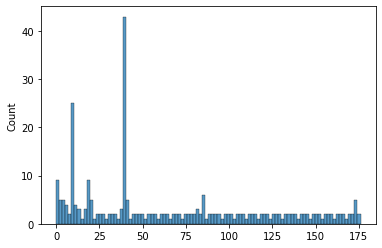

In [24]:
sns.histplot(data = clustering, bins = 100)

In [25]:
for i, x in enumerate(clustering):
    print(i, x, positions_list[i][0], len(positions_list[i][1]))

0 156 Rv0001 1
1 10 Rv0007 38
2 10 Rv0008c 39
3 148 Rv0021c 1
4 155 Rv0048c 1
5 154 Rv0058 1
6 153 Rv0071 2
7 152 Rv0089 1
8 151 Rv0104 2
9 150 Rv0106 1
10 149 Rv0115 3
11 17 Rv0128 2
12 17 Rv0129c 2
13 19 Rv0133 43
14 147 Rv0163 1
15 146 Rv0187 1
16 145 Rv0210 1
17 40 Rv0211 143
18 40 Rv0212c 136
19 40 Rv0233 140
20 38 Rv0243 1
21 38 Rv0244c 1
22 86 Rv0257 66
23 143 Rv0289 1
24 142 Rv0297 2
25 10 Rv0318c 45
26 141 Rv0340 1
27 140 Rv0341 1
28 139 Rv0349 2
29 138 Rv0378 1
30 40 Rv0384c 120
31 137 Rv0401 1
32 136 Rv0417 1
33 135 Rv0441c 2
34 134 Rv0454 1
35 133 Rv0500 1
36 132 Rv0500A 1
37 1 Rv0534c 34
38 86 Rv0579 67
39 131 Rv0610c 1
40 10 Rv0634A 31
41 10 Rv0637 39
42 130 Rv0640 1
43 129 Rv0650 1
44 128 Rv0654 1
45 127 Rv0656c 2
46 40 Rv0661c 147
47 18 Rv0666 1
48 40 Rv0668 145
49 40 Rv0669c 149
50 126 Rv0681 1
51 125 Rv0683 1
52 82 Rv0695 58
53 124 Rv0699 1
54 40 Rv0710 147
55 40 Rv0723 142
56 40 Rv0737 137
57 166 Rv0742 343
58 169 Rv0749A 3
59 40 Rv0751c 105
60 10 Rv0756c 40
61 123 R

In [28]:
positions_list[1]

('Rv0007',
 {(10888, 10956),
  (11113, 11180),
  (386273, 386208),
  (731495, 731562),
  (731604, 731672),
  (733525, 733592),
  (850712, 850646),
  (923874, 923807),
  (924000, 924068),
  (924111, 924179),
  (924214, 924282),
  (1025392, 1025325),
  (1113512, 1113579),
  (1138146, 1138080),
  (1177397, 1177465),
  (1446264, 1446197),
  (1828087, 1828019),
  (1946614, 1946682),
  (2510668, 2510602),
  (2581836, 2581768),
  (2619478, 2619411),
  (2765403, 2765335),
  (2765542, 2765607),
  (2794177, 2794245),
  (2827855, 2827922),
  (2835495, 2835562),
  (2969567, 2969501),
  (2969754, 2969821),
  (2969856, 2969921),
  (2969943, 2970009),
  (3348618, 3348551),
  (3431911, 3431844),
  (3559442, 3559374),
  (4081436, 4081369),
  (4126542, 4126610),
  (4168346, 4168426),
  (4216936, 4216869),
  (4222666, 4222585)})

In [10]:
for i in positions_list:
    if i[0] == 'Rv1133c':
        print(i)

('Rv1133c', {(309859, 309664), (1261679, 1261452)})
